In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pathlib
import sys
from os.path import join
path_to_file = str(pathlib.Path().resolve())

import pickle
retro_path = join(path_to_file, "..", "Results", "Retrospective")
alphas = [0.05, 0.1, 0.2]

dir_path = join(path_to_file, "../../")

### Visualize

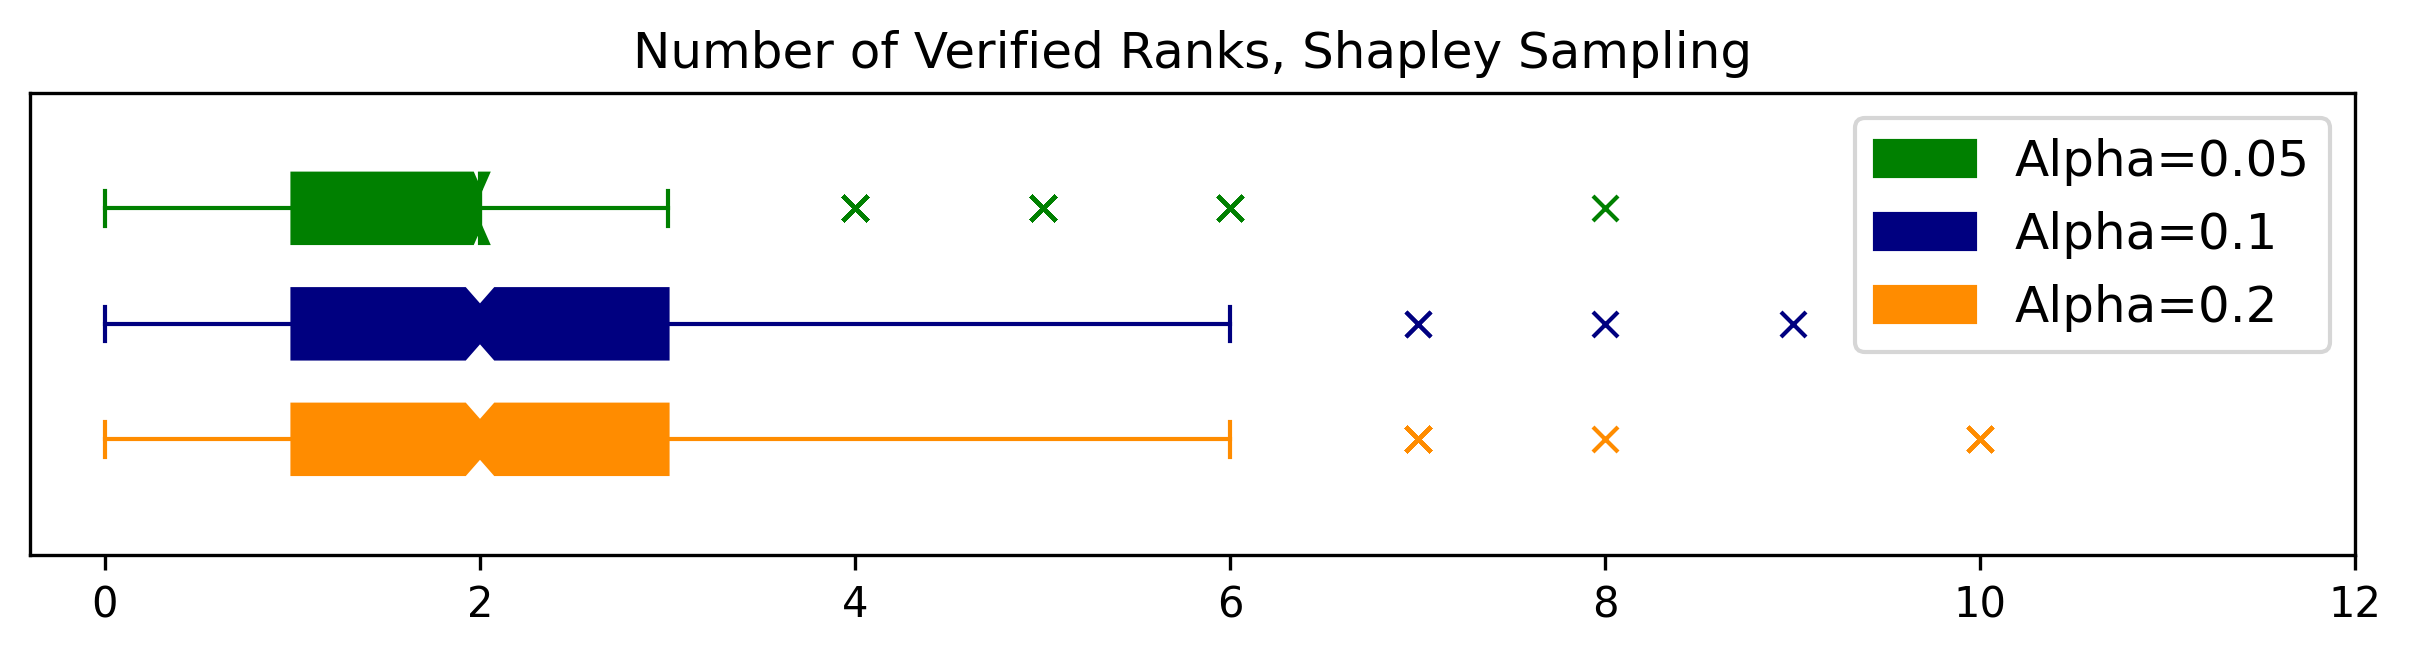

In [ ]:
method = "kernelshap" # "ss"
Method = "KernelSHAP" # "Shapley Sampling"
dataset = "credit"
with open(join(retro_path, method+"_"+dataset), 'rb') as f:
    retro_results = pickle.load(f)
shap_vals = retro_results["shap_vals"]
N_verified_all = retro_results["N_verified"]
N_verified = N_verified_all.reshape(-1, 3)

offset = 0.25#0.5
plt.figure(figsize=(10,2), dpi=300)
colors = ["green", "navy", "darkorange"]
offsets = np.array([offset, 0, -offset])
for i in range(3):
    c = colors[i]
    off = offsets[i]
    plt.boxplot(N_verified[:, i].T, positions=[off], notch=True, patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c, marker='x'),
            medianprops=dict(color=c), 
            vert=False
            )
    plt.xlim(right=np.max(N_verified)+2)
    plt.ylim(-.5, .5)

cols = ["Alpha="+str(alpha) for alpha in alphas]
patches = []
for i in range(3):
    patches.append(mpatches.Patch(color=colors[i], label=cols[i]))
plt.legend(handles=patches, fontsize='large', loc='upper right')
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.title(f"Number of Verified Ranks, {Method}")
plt.savefig(join(dir_path, "Experiments", "Figures", "num_stable_ranks_"+method+".pdf"), 
            bbox_inches="tight", format="pdf")
plt.show()
